MovieLens GRU Recommendation System - Enhanced Version
Checking CSV file format...
Ratings file shape: (5, 4)
Ratings columns: ['userId', 'movieId', 'rating', 'timestamp']
Sample ratings data:
   userId  movieId  rating   timestamp
0       1       16     4.0  1217897793
1       1       24     1.5  1217895807
2       1       32     4.0  1217896246
3       1       47     4.0  1217896556
4       1       50     4.0  1217896523


Movies file shape: (5, 3)
Movies columns: ['movieId', 'title', 'genres']
Sample movies data:
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                             

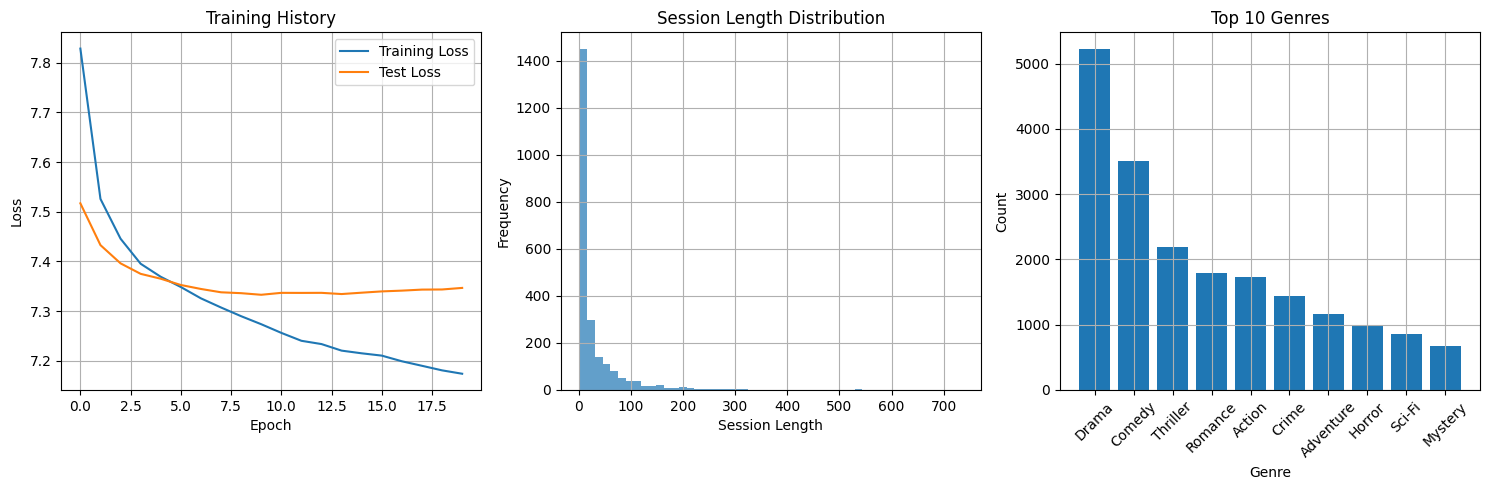


Evaluating model performance...
Evaluating model...

Evaluation Results:
Recall@1: 0.0043
Recall@5: 0.0209
Recall@10: 0.0376
Recall@20: 0.0681
MRR: 0.0139

Getting recommendations for User 1...
User 1 has watched 96 movies

Top 10 Movie Recommendations for User 1:
1. Alien (1979) (Genres: Horror|Sci-Fi, Score: 0.0019)
2. One Flew Over the Cuckoo's Nest (1975) (Genres: Drama, Score: 0.0018)

Getting recommendations based on watching movies [1, 2, 3]...

Recommendations based on watching movies [1, 2, 3]:
1. Star Wars: Episode IV - A New Hope (1977) (Genres: Action|Adventure|Sci-Fi, Score: 0.0041)
2. Pulp Fiction (1994) (Genres: Comedy|Crime|Drama|Thriller, Score: 0.0040)
3. Forrest Gump (1994) (Genres: Comedy|Drama|Romance|War, Score: 0.0038)
4. Shawshank Redemption, The (1994) (Genres: Crime|Drama, Score: 0.0037)
5. Silence of the Lambs, The (1991) (Genres: Crime|Horror|Thriller, Score: 0.0036)
6. Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981) (Genres: 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from collections import defaultdict, Counter
import warnings
warnings.filterwarnings('ignore')

class MovieLensSessionDataset(Dataset):
    """Dataset class for MovieLens session-based data"""
    def __init__(self, sessions, item_encoder, max_length=20):
        self.sessions = sessions
        self.item_encoder = item_encoder
        self.max_length = max_length
        self.data = self.prepare_data()

    def prepare_data(self):
        """Prepare session data for training"""
        data = []
        for session in self.sessions:
            if len(session) < 2:
                continue

            # Create input-target pairs for each session
            for i in range(1, len(session)):
                input_seq = session[:i]
                target = session[i]

                # Pad or truncate sequence
                if len(input_seq) > self.max_length:
                    input_seq = input_seq[-self.max_length:]

                # Convert to encoded values
                try:
                    encoded_seq = [self.item_encoder.transform([item])[0] for item in input_seq]
                    encoded_target = self.item_encoder.transform([target])[0]
                    data.append((encoded_seq, encoded_target))
                except:
                    continue

        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        input_seq, target = self.data[idx]

        # Pad sequence to max_length
        padded_seq = input_seq + [0] * (self.max_length - len(input_seq))

        return torch.tensor(padded_seq, dtype=torch.long), torch.tensor(target, dtype=torch.long)

class GRU4Rec(nn.Module):
    """GRU-based model for session-based recommendations"""
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, dropout=0.2):
        super(GRU4Rec, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers

        # Embedding layer
        self.embedding = nn.Embedding(input_size + 1, hidden_size, padding_idx=0)

        # GRU layers
        self.gru = nn.GRU(
            input_size=hidden_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True
        )

        # Output layer
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, hidden=None):
        # Embedding
        embedded = self.embedding(x)

        # GRU forward pass
        gru_out, hidden = self.gru(embedded, hidden)

        # Take the last output
        last_output = gru_out[:, -1, :]

        # Apply dropout and final linear layer
        output = self.dropout(last_output)
        output = self.fc(output)

        return output, hidden

class MovieLensGRURecommendationSystem:
    def __init__(self, hidden_size=128, num_layers=2, dropout=0.2, learning_rate=0.001):

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = dropout
        self.learning_rate = learning_rate

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")

        self.item_encoder = None
        self.model = None
        self.sessions = None
        self.movies = None
        self.ratings = None
        self.item_popularity = None

    def load_and_preprocess_data(self, ratings_file, movies_file, min_rating=2.5):
        """Load and preprocess the MovieLens dataset"""
        print("Loading MovieLens dataset for GRU-based recommendations...")

        # Load ratings data
        try:
            self.ratings = pd.read_csv(ratings_file)
            print(f"Loaded {len(self.ratings)} ratings")
        except Exception as e:
            print(f"Error loading ratings: {e}")
            return

        # Load movies data
        try:
            self.movies = pd.read_csv(movies_file)
            print(f"Loaded {len(self.movies)} movies")
        except Exception as e:
            print(f"Error loading movies: {e}")
            return

        # Clean movies data - handle empty genres
        self.clean_movies_data()

        # Filter ratings by minimum rating (implicit feedback)
        self.ratings = self.ratings[self.ratings['rating'] >= min_rating]
        print(f"After filtering ratings >= {min_rating}: {len(self.ratings)} ratings")

        # Convert timestamps to sessions
        self.create_sessions_from_ratings()

        # Preprocess sessions
        self.preprocess_sessions()

        print(f"Dataset processed: {len(self.ratings)} ratings")
        print(f"Sessions: {len(self.sessions)}")
        print(f"Unique movies: {len(self.item_encoder.classes_)}")
        print(f"Average session length: {np.mean([len(s) for s in self.sessions]):.2f}")

    def clean_movies_data(self):
        """Clean movies data and handle empty genres"""
        print("Cleaning movies data...")

        # Handle missing or empty genres
        self.movies['genres'] = self.movies['genres'].fillna('Unknown')

        # Replace empty strings with 'Unknown'
        self.movies['genres'] = self.movies['genres'].replace('', 'Unknown')
        self.movies['genres'] = self.movies['genres'].replace('(no genres listed)', 'Unknown')

        # Handle missing titles
        self.movies['title'] = self.movies['title'].fillna('Unknown Title')

        # Count movies with empty/unknown genres
        unknown_genres_count = len(self.movies[self.movies['genres'] == 'Unknown'])
        print(f"Movies with unknown/empty genres: {unknown_genres_count}")

        # Print genre statistics
        all_genres = []
        for genres_str in self.movies['genres']:
            if isinstance(genres_str, str) and genres_str != 'Unknown':
                genres = genres_str.split('|')
                all_genres.extend(genres)

        genre_counts = Counter(all_genres)
        print(f"Total unique genres found: {len(genre_counts)}")
        print(f"Most common genres: {dict(genre_counts.most_common(5))}")

    def create_sessions_from_ratings(self):
        """Convert user ratings to sessions based on temporal patterns"""
        print("Creating sessions from user ratings...")

        # Sort by user and timestamp
        self.ratings = self.ratings.sort_values(['userId', 'timestamp'])

        # Group by user and create sessions based on time gaps
        user_sessions = []
        session_gap_hours = 24  # 24 hours gap to split sessions

        for user_id, user_data in self.ratings.groupby('userId'):
            user_data = user_data.sort_values('timestamp')

            if len(user_data) < 2:
                continue

            # Convert timestamps to datetime
            timestamps = pd.to_datetime(user_data['timestamp'], unit='s')
            movies = user_data['movieId'].tolist()

            # Split into sessions based on time gaps
            current_session = [movies[0]]

            for i in range(1, len(movies)):
                time_diff = (timestamps.iloc[i] - timestamps.iloc[i-1]).total_seconds() / 3600

                if time_diff > session_gap_hours:
                    # Start new session
                    if len(current_session) >= 2:
                        user_sessions.append(current_session)
                    current_session = [movies[i]]
                else:
                    # Continue current session
                    current_session.append(movies[i])

            # Add the last session
            if len(current_session) >= 2:
                user_sessions.append(current_session)

        self.sessions = user_sessions
        print(f"Created {len(self.sessions)} sessions from user ratings")

    def preprocess_sessions(self):
        """Preprocess sessions for GRU training"""
        # Filter sessions and items
        session_lengths = [len(s) for s in self.sessions]
        valid_sessions = [s for s in self.sessions if len(s) >= 2]
        self.sessions = valid_sessions

        # Get all unique items from sessions
        all_items = set()
        for session in self.sessions:
            all_items.update(session)

        # Filter items that appear in at least 5 sessions
        item_counts = Counter()
        for session in self.sessions:
            for item in session:
                item_counts[item] += 1

        valid_items = {item for item, count in item_counts.items() if count >= 5}

        # Filter sessions to only include valid items
        filtered_sessions = []
        for session in self.sessions:
            filtered_session = [item for item in session if item in valid_items]
            if len(filtered_session) >= 2:
                filtered_sessions.append(filtered_session)

        self.sessions = filtered_sessions

        # Encode items
        all_valid_items = list(valid_items)
        self.item_encoder = LabelEncoder()
        self.item_encoder.fit(all_valid_items)

        # Calculate item popularity
        self.item_popularity = dict(item_counts)

        print(f"Processed {len(self.sessions)} sessions")
        print(f"Vocabulary size: {len(self.item_encoder.classes_)}")

    def prepare_datasets(self, test_size=0.2, max_length=20):
        """Prepare training and test datasets"""
        # Split sessions
        train_sessions, test_sessions = train_test_split(
            self.sessions, test_size=test_size, random_state=42
        )

        # Create datasets
        self.train_dataset = MovieLensSessionDataset(train_sessions, self.item_encoder, max_length)
        self.test_dataset = MovieLensSessionDataset(test_sessions, self.item_encoder, max_length)

        print(f"Training samples: {len(self.train_dataset)}")
        print(f"Test samples: {len(self.test_dataset)}")

    def build_model(self):
        """Build the GRU model"""
        vocab_size = len(self.item_encoder.classes_)

        self.model = GRU4Rec(
            input_size=vocab_size,
            hidden_size=self.hidden_size,
            output_size=vocab_size,
            num_layers=self.num_layers,
            dropout=self.dropout
        ).to(self.device)

        print(f"Model built with {sum(p.numel() for p in self.model.parameters())} parameters")

    def train_model(self, epochs=20, batch_size=512, patience=10):
        """Train the GRU model"""
        if not hasattr(self, 'train_dataset'):
            self.prepare_datasets()

        if self.model is None:
            self.build_model()

        # Data loaders
        train_loader = DataLoader(
            self.train_dataset, batch_size=batch_size, shuffle=True, num_workers=2
        )
        test_loader = DataLoader(
            self.test_dataset, batch_size=batch_size, shuffle=False, num_workers=2
        )

        # Loss and optimizer
        criterion = nn.CrossEntropyLoss(ignore_index=0)
        optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.7)

        # Training loop
        train_losses = []
        test_losses = []
        best_test_loss = float('inf')
        patience_counter = 0

        print("Starting training...")

        for epoch in range(epochs):
            # Training phase
            self.model.train()
            train_loss = 0.0
            num_batches = 0

            for batch_inputs, batch_targets in train_loader:
                batch_inputs = batch_inputs.to(self.device)
                batch_targets = batch_targets.to(self.device)

                optimizer.zero_grad()

                outputs, _ = self.model(batch_inputs)
                loss = criterion(outputs, batch_targets)

                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                optimizer.step()

                train_loss += loss.item()
                num_batches += 1

            avg_train_loss = train_loss / num_batches
            train_losses.append(avg_train_loss)

            # Evaluation phase
            self.model.eval()
            test_loss = 0.0
            num_test_batches = 0

            with torch.no_grad():
                for batch_inputs, batch_targets in test_loader:
                    batch_inputs = batch_inputs.to(self.device)
                    batch_targets = batch_targets.to(self.device)

                    outputs, _ = self.model(batch_inputs)
                    loss = criterion(outputs, batch_targets)

                    test_loss += loss.item()
                    num_test_batches += 1

            avg_test_loss = test_loss / num_test_batches
            test_losses.append(avg_test_loss)

            scheduler.step()

            print(f"Epoch {epoch+1}/{epochs}: Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")

            # Early stopping
            if avg_test_loss < best_test_loss:
                best_test_loss = avg_test_loss
                patience_counter = 0
                # Save best model
                torch.save(self.model.state_dict(), 'best_movielens_gru_model.pth')
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping at epoch {epoch+1}")
                    break

        # Load best model
        self.model.load_state_dict(torch.load('best_movielens_gru_model.pth'))

        # Plot training history
        self.plot_training_history(train_losses, test_losses)

        return train_losses, test_losses

    def predict_next_movies(self, watched_movies, top_k=5):
        """Predict next movies for a given list of watched movies"""
        if self.model is None:
            print("Model not trained yet!")
            return []

        self.model.eval()

        try:
            # Filter watched movies to only include those in our vocabulary
            valid_watched = [movie for movie in watched_movies
                           if movie in self.item_encoder.classes_]

            if not valid_watched:
                print("No valid movies in the watched list")
                return self.get_popular_recommendations(top_k)

            # Encode movies
            encoded_movies = [self.item_encoder.transform([movie])[0] for movie in valid_watched]

            # Pad sequence
            max_length = 20  # Should match training max_length
            if len(encoded_movies) > max_length:
                encoded_movies = encoded_movies[-max_length:]

            padded_seq = encoded_movies + [0] * (max_length - len(encoded_movies))

            # Convert to tensor
            input_tensor = torch.tensor([padded_seq], dtype=torch.long).to(self.device)

            # Get predictions
            with torch.no_grad():
                outputs, _ = self.model(input_tensor)
                probabilities = torch.softmax(outputs, dim=1)
                top_indices = torch.topk(probabilities, top_k * 2, dim=1)[1]  # Get more to filter
                top_probs = torch.topk(probabilities, top_k * 2, dim=1)[0]

            # Decode predictions
            recommendations = []
            for i in range(top_k * 2):
                item_idx = top_indices[0][i].item()
                prob = top_probs[0][i].item()

                if item_idx < len(self.item_encoder.classes_):
                    movie_id = self.item_encoder.inverse_transform([item_idx])[0]

                    # Don't recommend movies already watched
                    if movie_id not in watched_movies:
                        recommendations.append((movie_id, prob))

                        if len(recommendations) >= top_k:
                            break

            return recommendations

        except Exception as e:
            print(f"Error in prediction: {e}")
            return self.get_popular_recommendations(top_k)

    def get_popular_recommendations(self, n_recommendations=10):
        """Get popular movies as fallback recommendations"""
        sorted_popular = sorted(self.item_popularity.items(),
                              key=lambda x: x[1], reverse=True)
        return [(movie_id, count/sum(self.item_popularity.values()))
                for movie_id, count in sorted_popular[:n_recommendations]]

    def get_movie_info(self, movie_id):
        """Get movie information with safe handling of empty fields"""
        movie_info = self.movies[self.movies['movieId'] == movie_id]
        if not movie_info.empty:
            movie_data = movie_info.iloc[0]
            return {
                'movieId': movie_id,
                'title': movie_data['title'] if pd.notna(movie_data['title']) else f'Movie {movie_id}',
                'genres': movie_data['genres'] if pd.notna(movie_data['genres']) and movie_data['genres'] != '' else 'Unknown',
            }
        else:
            return {
                'movieId': movie_id,
                'title': f'Movie {movie_id}',
                'genres': 'Unknown',
            }

    def format_recommendations(self, recommendations):
        """Format recommendations with movie details"""
        rec_list = []
        for movie_id, score in recommendations:
            movie_info = self.get_movie_info(movie_id)
            movie_info['score'] = score
            movie_info['popularity'] = self.item_popularity.get(movie_id, 0)
            rec_list.append(movie_info)
        return rec_list

    def evaluate_model(self, k_values=[1, 5, 10, 20]):
        """Evaluate model using Recall@K and MRR"""
        if not hasattr(self, 'test_dataset'):
            print("No test dataset available")
            return

        self.model.eval()
        test_loader = DataLoader(self.test_dataset, batch_size=256, shuffle=False)

        total_samples = 0
        recall_at_k = {k: 0 for k in k_values}
        mrr_scores = []

        print("Evaluating model...")

        with torch.no_grad():
            for batch_inputs, batch_targets in test_loader:
                batch_inputs = batch_inputs.to(self.device)
                batch_targets = batch_targets.to(self.device)

                outputs, _ = self.model(batch_inputs)

                for i in range(batch_inputs.size(0)):
                    target = batch_targets[i].item()
                    if target == 0:  # Skip padding
                        continue

                    # Get top predictions
                    probs = torch.softmax(outputs[i], dim=0)
                    top_items = torch.topk(probs, max(k_values))[1]

                    # Calculate metrics
                    target_rank = None
                    for rank, item_idx in enumerate(top_items):
                        if item_idx.item() == target:
                            target_rank = rank + 1
                            break

                    # Update recall@k
                    for k in k_values:
                        if target_rank and target_rank <= k:
                            recall_at_k[k] += 1

                    # Update MRR
                    if target_rank:
                        mrr_scores.append(1.0 / target_rank)
                    else:
                        mrr_scores.append(0.0)

                    total_samples += 1

        # Calculate final metrics
        results = {}
        for k in k_values:
            results[f'Recall@{k}'] = recall_at_k[k] / total_samples

        results['MRR'] = np.mean(mrr_scores)

        print("\nEvaluation Results:")
        for metric, value in results.items():
            print(f"{metric}: {value:.4f}")

        return results

    def plot_training_history(self, train_losses, test_losses):
        """Plot training and validation loss with safe genre handling"""
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.plot(train_losses, label='Training Loss')
        plt.plot(test_losses, label='Test Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training History')
        plt.legend()
        plt.grid(True)

        plt.subplot(1, 3, 2)
        session_lengths = [len(s) for s in self.sessions]
        plt.hist(session_lengths, bins=50, alpha=0.7)
        plt.xlabel('Session Length')
        plt.ylabel('Frequency')
        plt.title('Session Length Distribution')
        plt.grid(True)

        plt.subplot(1, 3, 3)
        # Plot genre distribution with safe handling
        genre_counts = Counter()
        for _, movie in self.movies.iterrows():
            genres_str = movie['genres']
            if pd.notna(genres_str) and genres_str != '' and genres_str != 'Unknown':
                genres = genres_str.split('|')
                for genre in genres:
                    if genre.strip():  # Only count non-empty genres
                        genre_counts[genre.strip()] += 1

        if genre_counts:
            genres, counts = zip(*genre_counts.most_common(10))
            plt.bar(genres, counts)
            plt.xlabel('Genre')
            plt.ylabel('Count')
            plt.title('Top 10 Genres')
            plt.xticks(rotation=45)
            plt.grid(True)
        else:
            plt.text(0.5, 0.5, 'No genre data available',
                    horizontalalignment='center', verticalalignment='center',
                    transform=plt.gca().transAxes)
            plt.title('Genre Distribution')

        plt.tight_layout()
        plt.show()

    def recommend_for_user(self, user_id, top_k=10):
        """Recommend movies for a specific user based on their rating history"""
        user_ratings = self.ratings[self.ratings['userId'] == user_id]

        if user_ratings.empty:
            print(f"User {user_id} not found")
            return []

        # Get movies watched by user (sorted by timestamp)
        watched_movies = user_ratings.sort_values('timestamp')['movieId'].tolist()

        print(f"User {user_id} has watched {len(watched_movies)} movies")

        # Get recommendations
        recommendations = self.predict_next_movies(watched_movies, top_k)
        formatted_recs = self.format_recommendations(recommendations)

        return formatted_recs

    def save_model(self, filepath):
        """Save the trained model"""
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'item_encoder': self.item_encoder,
            'model_params': {
                'hidden_size': self.hidden_size,
                'num_layers': self.num_layers,
                'dropout': self.dropout
            }
        }, filepath)
        print(f"Model saved to {filepath}")

    def load_model(self, filepath):
        """Load a trained model"""
        checkpoint = torch.load(filepath)

        self.item_encoder = checkpoint['item_encoder']
        params = checkpoint['model_params']

        vocab_size = len(self.item_encoder.classes_)
        self.model = GRU4Rec(
            input_size=vocab_size,
            hidden_size=params['hidden_size'],
            output_size=vocab_size,
            num_layers=params['num_layers'],
            dropout=params['dropout']
        ).to(self.device)

        self.model.load_state_dict(checkpoint['model_state_dict'])
        print(f"Model loaded from {filepath}")

    def analyze_data_quality(self):
        """Analyze data quality including empty genres"""
        print("\n" + "="*60)
        print("DATA QUALITY ANALYSIS")
        print("="*60)

        # Movies analysis
        total_movies = len(self.movies)
        print(f"Total movies: {total_movies}")

        # Genre analysis
        empty_genres = self.movies[
            (self.movies['genres'].isna()) |
            (self.movies['genres'] == '') |
            (self.movies['genres'] == 'Unknown') |
            (self.movies['genres'] == '(no genres listed)')
        ]
        print(f"Movies with empty/unknown genres: {len(empty_genres)} ({len(empty_genres)/total_movies*100:.1f}%)")

        # Title analysis
        empty_titles = self.movies[
            (self.movies['title'].isna()) |
            (self.movies['title'] == '') |
            (self.movies['title'] == 'Unknown Title')
        ]
        print(f"Movies with empty/unknown titles: {len(empty_titles)} ({len(empty_titles)/total_movies*100:.1f}%)")

        # Genre distribution
        all_genres = []
        for genres_str in self.movies['genres']:
            if pd.notna(genres_str) and genres_str not in ['', 'Unknown', '(no genres listed)']:
                genres = genres_str.split('|')
                all_genres.extend([g.strip() for g in genres if g.strip()])

        genre_counts = Counter(all_genres)
        print(f"\nGenre statistics:")
        print(f"Total unique genres: {len(genre_counts)}")
        print(f"Top 5 genres: {dict(genre_counts.most_common(5))}")

        # Ratings analysis
        if self.ratings is not None:
            print(f"\nRatings statistics:")
            print(f"Total ratings: {len(self.ratings)}")
            print(f"Rating distribution:")
            print(self.ratings['rating'].value_counts().sort_index())

            # Users and movies with ratings
            unique_users = self.ratings['userId'].nunique()
            unique_rated_movies = self.ratings['movieId'].nunique()
            print(f"Unique users: {unique_users}")
            print(f"Unique movies with ratings: {unique_rated_movies}")
            print(f"Movies without ratings: {total_movies - unique_rated_movies}")

        print("="*60)

# Example usage and demonstration
def main():
    # Initialize the MovieLens GRU-based recommendation system
    rec_system = MovieLensGRURecommendationSystem(
        hidden_size=128,
        num_layers=4,
        dropout=0.2,
        learning_rate=0.0001
    )

    # Load and preprocess data from your CSV files
    print("Loading MovieLens dataset from CSV files...")

    # Make sure your CSV files are in the same directory as this script
    # ratings.csv should have columns: userId,movieId,rating,timestamp
    # movies.csv should have columns: movieId,title,genres

    try:
        rec_system.load_and_preprocess_data('ratings.csv', 'movies.csv', min_rating=3)

        # Analyze data quality
        rec_system.analyze_data_quality()

    except FileNotFoundError as e:
        print(f"Error: Could not find CSV file - {e}")
        print("Please make sure 'ratings.csv' and 'movies.csv' are in the same directory as this script")
        print("\nExpected format:")
        print("ratings.csv: userId,movieId,rating,timestamp")
        print("movies.csv: movieId,title,genres")
        return None

    # Train the model
    print("\nStarting model training...")
    train_losses, test_losses = rec_system.train_model(epochs=20, batch_size=256)

    # Evaluate the model
    print("\nEvaluating model performance...")
    evaluation_results = rec_system.evaluate_model()

    # Test recommendations for a specific user
    user_id = 1
    print(f"\nGetting recommendations for User {user_id}...")
    user_recommendations = rec_system.recommend_for_user(user_id, top_k=10)

    if user_recommendations:
        print(f"\nTop 10 Movie Recommendations for User {user_id}:")
        for i, rec in enumerate(user_recommendations, 1):
            print(f"{i}. {rec['title']} (Genres: {rec['genres']}, Score: {rec['score']:.4f})")

    # Test recommendations based on a custom movie list
    # Get some actual movie IDs from the dataset
    sample_movies = rec_system.movies['movieId'].head(3).tolist()
    print(f"\nGetting recommendations based on watching movies {sample_movies}...")

    custom_recommendations = rec_system.predict_next_movies(sample_movies, top_k=10)
    formatted_custom_recs = rec_system.format_recommendations(custom_recommendations)

    if formatted_custom_recs:
        print(f"\nRecommendations based on watching movies {sample_movies}:")
        for i, rec in enumerate(formatted_custom_recs, 1):
            print(f"{i}. {rec['title']} (Genres: {rec['genres']}, Score: {rec['score']:.4f})")

    # Save the model
    print("\nSaving trained model...")
    rec_system.save_model('movielens_gru_model.pth')

    print("\nTraining completed successfully!")
    return rec_system

# Helper function to check CSV file format
def check_csv_format(ratings_file='ratings.csv', movies_file='movies.csv'):
    """Check if CSV files have the correct format"""
    try:
        # Check ratings file
        ratings_df = pd.read_csv(ratings_file, nrows=5)
        print(f"Ratings file shape: {ratings_df.shape}")
        print(f"Ratings columns: {list(ratings_df.columns)}")
        print(f"Sample ratings data:")
        print(ratings_df.head())

        expected_ratings_cols = ['userId', 'movieId', 'rating', 'timestamp']
        missing_cols = [col for col in expected_ratings_cols if col not in ratings_df.columns]
        if missing_cols:
            print(f"WARNING: Missing columns in ratings.csv: {missing_cols}")

        print("\n" + "="*50 + "\n")

        # Check movies file
        movies_df = pd.read_csv(movies_file, nrows=5)
        print(f"Movies file shape: {movies_df.shape}")
        print(f"Movies columns: {list(movies_df.columns)}")
        print(f"Sample movies data:")
        print(movies_df.head())

        expected_movies_cols = ['movieId', 'title', 'genres']
        missing_cols = [col for col in expected_movies_cols if col not in movies_df.columns]
        if missing_cols:
            print(f"WARNING: Missing columns in movies.csv: {missing_cols}")

        # Check for empty genres specifically
        print(f"\nGenre data analysis:")
        if 'genres' in movies_df.columns:
            empty_genres = movies_df['genres'].isna().sum()
            empty_string_genres = (movies_df['genres'] == '').sum()
            no_genres_listed = (movies_df['genres'] == '(no genres listed)').sum()

            print(f"Movies with NaN genres: {empty_genres}")
            print(f"Movies with empty string genres: {empty_string_genres}")
            print(f"Movies with '(no genres listed)': {no_genres_listed}")
            print(f"Total problematic genre entries: {empty_genres + empty_string_genres + no_genres_listed}")

            # Show examples of genre data
            print(f"\nSample genre entries:")
            genre_samples = movies_df['genres'].dropna().head(10).tolist()
            for i, genre in enumerate(genre_samples):
                print(f"  {i+1}. '{genre}'")

        return True

    except FileNotFoundError as e:
        print(f"Error: {e}")
        print("Please make sure both 'ratings.csv' and 'movies.csv' are in the current directory")
        return False
    except Exception as e:
        print(f"Error reading CSV files: {e}")
        return False

def create_sample_data():
    """Create sample MovieLens-like data for testing when real data is not available"""
    print("Creating sample data for testing...")

    # Create sample movies data
    sample_movies = pd.DataFrame({
        'movieId': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
        'title': [
            'Toy Story (1995)',
            'Jumanji (1995)',
            'Grumpier Old Men (1995)',
            'Waiting to Exhale (1995)',
            'Father of the Bride Part II (1995)',
            'Heat (1995)',
            'Sabrina (1995)',
            'Tom and Huck (1995)',
            'Sudden Death (1995)',
            'GoldenEye (1995)'
        ],
        'genres': [
            'Adventure|Animation|Children|Comedy|Fantasy',
            'Adventure|Children|Fantasy',
            'Comedy|Romance',
            'Comedy|Drama|Romance',
            'Comedy',
            'Action|Crime|Thriller',
            'Comedy|Romance',
            '', # Empty genre example
            'Action',
            '(no genres listed)' # No genres listed example
        ]
    })

    # Create sample ratings data
    np.random.seed(42)
    n_users = 100
    n_ratings = 1000

    sample_ratings = pd.DataFrame({
        'userId': np.random.randint(1, n_users + 1, n_ratings),
        'movieId': np.random.choice(sample_movies['movieId'], n_ratings),
        'rating': np.random.choice([1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0], n_ratings),
        'timestamp': np.random.randint(946684800, 1577836800, n_ratings)  # 2000-2020
    })

    # Save sample data
    sample_movies.to_csv('sample_movies.csv', index=False)
    sample_ratings.to_csv('sample_ratings.csv', index=False)

    print("Sample data created:")
    print(f"- sample_movies.csv: {len(sample_movies)} movies")
    print(f"- sample_ratings.csv: {len(sample_ratings)} ratings")
    print("You can use these files to test the recommendation system")

    return 'sample_ratings.csv', 'sample_movies.csv'

if __name__ == "__main__":
    print("MovieLens GRU Recommendation System - Enhanced Version")
    print("="*60)

    # First, check if CSV files exist and have correct format
    print("Checking CSV file format...")

    if check_csv_format():
        print("\nCSV files look good! Starting recommendation system...")
        rec_system = main()
    else:
        print("\nCSV files not found or have issues.")
        create_sample = input("Would you like to create sample data for testing? (y/n): ").lower().strip()

        if create_sample == 'y':
            ratings_file, movies_file = create_sample_data()
            print(f"\nUsing sample data: {ratings_file}, {movies_file}")

            # Initialize system with sample data
            rec_system = MovieLensGRURecommendationSystem(
                hidden_size=128,  # Smaller for sample data
                num_layers=2,
                dropout=0.2,
                learning_rate=0.001
            )

            try:
                rec_system.load_and_preprocess_data(ratings_file, movies_file, min_rating=3.0)
                rec_system.analyze_data_quality()

                # Train with fewer epochs for sample data
                print("\nTraining on sample data...")
                train_losses, test_losses = rec_system.train_model(epochs=10, batch_size=32)

                # Test recommendations
                print("\nTesting recommendations...")
                sample_movies = [1, 2, 3]
                recommendations = rec_system.predict_next_movies(sample_movies, top_k=5)
                formatted_recs = rec_system.format_recommendations(recommendations)

                if formatted_recs:
                    print(f"\nRecommendations based on movies {sample_movies}:")
                    for i, rec in enumerate(formatted_recs, 1):
                        print(f"{i}. {rec['title']} (Genres: {rec['genres']}, Score: {rec['score']:.4f})")

                print("\nSample data testing completed successfully!")

            except Exception as e:
                print(f"Error with sample data: {e}")
        else:
            print("\nPlease fix the CSV file issues before running the recommendation system.")
            print("\nExpected format:")
            print("ratings.csv: userId,movieId,rating,timestamp")
            print("movies.csv: movieId,title,genres")
            print("\nNote: Some movies may have empty genres - this is now handled properly!")